In [43]:
# Import public packages and functions
import os
import pandas as pd
import numpy as np
import sys
import json
from pathlib import Path
import pyvista as pv

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

import warnings
warnings.filterwarnings("ignore")

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

pd.set_option("display.precision", 3)

import utils_io, utils_misc, utils_cortical_atlas, utils_plotting

from lib_data import DATA_IO
from lib_Subcortical_Atlases import Distal_Atlas

# 1. DATA LOADING

In [45]:
#####################################################################
# STEP 1: Loading PSD Data
#####################################################################

# load ECOG-PSD dataframe
ECOG_PSD_controlateral = utils_io.load_ECoG_event_PSD(event_category="tapping", event_laterality="controlateral")

# concat all different dyskinesia severity dataframe into single dataframe
ECOG_PSD = pd.DataFrame()
for severity in ECOG_PSD_controlateral.keys():
    ECOG_PSD = pd.concat([ECOG_PSD, ECOG_PSD_controlateral[severity]], ignore_index=True)

# assign severity scores
ECOG_PSD["severity"] = ECOG_PSD['dyskinesia_arm']
ECOG_PSD.loc[(ECOG_PSD['severity'] != "none"), 'severity']                                        = 'LID'
ECOG_PSD.loc[(ECOG_PSD['event_start_time'] < 30)  & (ECOG_PSD['severity'] == "none"), 'severity'] = 'noLID_noDOPA'
ECOG_PSD.loc[(ECOG_PSD['event_start_time'] >= 30) & (ECOG_PSD['severity'] == "none"), 'severity'] = 'noLID_DOPA'


# arrange the dataframe
ECOG_PSD['hemisphere'] = ECOG_PSD['ECoG_hemisphere']
ECOG_PSD['channel']    = ECOG_PSD['ECoG_channel']

ECOG_PSD = ECOG_PSD[['patient', 'hemisphere', 'channel', "event_no",
                     'pre_event_theta_mean', 'pre_event_alpha_mean', 
                     'pre_event_beta_low_mean','pre_event_beta_high_mean','pre_event_gamma_mean',
                     'event_theta_mean', 'event_alpha_mean', 
                     'event_beta_low_mean','event_beta_high_mean','event_gamma_mean', 
                     'post_event_theta_mean', 'post_event_alpha_mean',
                     'post_event_beta_low_mean','post_event_beta_high_mean','post_event_gamma_mean',
                     'severity']]

features = ['pre_event_theta_mean', 'pre_event_alpha_mean', 'pre_event_beta_low_mean',
            'pre_event_beta_high_mean','pre_event_gamma_mean',
            'event_theta_mean', 'event_alpha_mean', 'event_beta_low_mean',
            'event_beta_high_mean','event_gamma_mean', 
            'post_event_theta_mean', 'post_event_alpha_mean',
            'post_event_beta_low_mean','post_event_beta_high_mean','post_event_gamma_mean'] 

#####################################################################
# STEP 2: Loading Lead Positions in Sensory-Motor STN
#####################################################################

# load ECoG channel MNI coordinates
MNI_ECoG_channels   = pd.read_pickle(DATA_IO.path_coordinates + "MNI_ECoG_channels.pkl")
MNI_ECoG_channels.x = MNI_ECoG_channels.x.abs()


#####################################################################
# STEP 3: Merge PSD and Lead Position Data
#####################################################################

dataset                     = pd.merge(ECOG_PSD, MNI_ECoG_channels[["patient","hemisphere","channel","x","y","z","AAL3_cortex"]], on=['patient', 'hemisphere', 'channel'])
dataset["severity_numeric"] = dataset['severity'].map({'noLID_noDOPA':0, 'noLID_DOPA':1, 'LID':2})
#dataset_motor               = dataset[(dataset.AAL3_cortex == "Motor cortex")]
#dataset_sensory             = dataset[(dataset.AAL3_cortex == "Sensory cortex")]


#####################################################################
# STEP 4: Adjust the Axes
#####################################################################
dataset["x"] = dataset["x"] - dataset["x"].min()
dataset["y"] = dataset["y"] - dataset["y"].min()
dataset["z"] = dataset["z"] - dataset["z"].min()

# 2. METHODS

In [7]:
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from scipy.stats import norm

def extract_spatial_dataset(dataset, event_segment, frequency_band, MNI_axis):
    
    if(event_segment == "pre")     : event_prefix = "pre_event_"
    elif(event_segment == "event") : event_prefix = "event_"
    elif(event_segment == "post")  : event_prefix = "post_event_"
        
    dataset_spatial                = dataset[["patient", "hemisphere", "channel", event_prefix + frequency_band + "_mean", MNI_axis, "severity_numeric"]]
    dataset_spatial["channel_id"]  = dataset["patient"] + "_" + dataset["hemisphere"] + "_" + dataset["channel"]
    dataset_spatial                = dataset_spatial[["patient", "channel_id", MNI_axis, event_prefix + frequency_band + "_mean", "severity_numeric"]]
    dataset_spatial                = dataset_spatial.rename(columns={event_prefix + frequency_band + "_mean": frequency_band})

    return dataset_spatial

def get_slope_definitions_for_severity_levels(result, MNI_axis):
    
    names = result.model.exog_names
    def idx(name): return names.index(name)
    
    # Define contrasts
    contrast_0 = np.zeros(len(names)); contrast_0[idx(MNI_axis)] = 1
    contrast_1 = np.zeros(len(names)); contrast_1[idx(MNI_axis)] = 1; contrast_1[idx(f"{MNI_axis}:C(severity_numeric)[T.1]")] = 1
    contrast_2 = np.zeros(len(names)); contrast_2[idx(MNI_axis)] = 1; contrast_2[idx(f"{MNI_axis}:C(severity_numeric)[T.2]")] = 1
    
    severities = ["noLID_noDOPA", "noLID_DOPA", "LID"]
    contrasts  = [contrast_0, contrast_1, contrast_2]
    
    results = []
    for severity, contrast in zip(severities, contrasts):
        test            = result.t_test(contrast.reshape(1, -1))
        est             = test.effect[0]
        ci_low, ci_high = test.conf_int()[0]
        pval            = test.pvalue
        results.append({"severity": severity, "slope": est, "ci_lower": ci_low, "ci_upper": ci_high,"p_value": pval})
    
    return pd.DataFrame(results)

def fit_LME_for_spatial_dynamics(dataset, frequency_band, event_segment, MNI_axis):

    # STEP 1: get the spatial data for selected parameters
    dataset_spatial = extract_spatial_dataset(dataset, event_segment=event_segment, frequency_band=frequency_band, MNI_axis=MNI_axis)

    # STEP 2: LME modelling: random intercept + fixed slopes
        
    model     = smf.mixedlm(formula    = f"{frequency_band} ~ {MNI_axis} * C(severity_numeric)", 
                            data       = dataset_spatial, 
                            groups     = dataset_spatial["patient"], 
                            vc_formula = {"channel": "0 + C(channel_id)"})  # random intercept per channel
    result    = model.fit()

    # STEP 3: get slope definitions for severity levels 
    slopes_definitions_by_severity                  = get_slope_definitions_for_severity_levels(result, MNI_axis)
    slopes_definitions_by_severity["frequency"]     = frequency_band
    slopes_definitions_by_severity["axis"]          = MNI_axis
    slopes_definitions_by_severity["event_segment"] = event_segment
    slopes_definitions_by_severity["p_value"]       = multipletests(slopes_definitions_by_severity.p_value.to_list(), method="holm")[1]

    # STEP 4: get slope differences between severity levels 
    slopes_differences_between_severity                  = slope_differences_between_severity_levels(result, MNI_axis)
    slopes_differences_between_severity["frequency"]     = frequency_band
    slopes_differences_between_severity["axis"]          = MNI_axis
    slopes_differences_between_severity["event_segment"] = event_segment
    slopes_differences_between_severity["p_value"]       = multipletests(slopes_differences_between_severity.p_value.to_list(), method="holm")[1]

    return slopes_definitions_by_severity, slopes_differences_between_severity

def slope_differences_between_severity_levels(result, MNI_axis):
    
    # fixed effect names for indexing
    names = result.fe_params.index.tolist()
    idx   = lambda name: names.index(name)
    
    # Differences
    contrast_01                                    = np.zeros(len(names))  # slope_0 - slope_1 = - z:C(severity_numeric)[T.1]
    contrast_01[idx(f"{MNI_axis}:C(severity_numeric)[T.1]")] = -1

    contrast_12                                    = np.zeros(len(names))  # slope_1 - slope_2 = z:C(severity_numeric)[T.1] - z:C(severity_numeric)[T.2]
    contrast_12[idx(f"{MNI_axis}:C(severity_numeric)[T.1]")] = 1
    contrast_12[idx(f"{MNI_axis}:C(severity_numeric)[T.2]")] = -1

    contrast_02                                    = np.zeros(len(names))  # slope_0 - slope_2 = - z:C(severity_numeric)[T.2]
    contrast_02[idx(f"{MNI_axis}:C(severity_numeric)[T.2]")] = -1

    results                                        = []

    for name, contrast in zip(["noLID-noDOPA vs noLID-DOPA", "noLID-DOPA vs LID", "noLID-noDOPA vs LID"],[contrast_01, contrast_12, contrast_02]):
        test            = result.t_test(contrast.reshape(1, -1))  # Ensure 2D shape
        est             = test.effect[0]
        ci_low, ci_high = test.conf_int()[0]
        pval            = test.pvalue.item()

        results.append({"comparison": name, "slope_diff": est, "ci_lower": ci_low, "ci_upper": ci_high,"p_value": pval})

    return pd.DataFrame(results)


def plot_slopes_with_custom_errorbars(df, colors, ax=None):

    yerr           = np.array([df['slope'] - df['ci_lower'], df['ci_upper'] - df['slope']])
    ax             = sns.pointplot(data=df, x='severity', y='slope', join=False, palette=colors, markersize=2.5, ax=ax)
    x_coords       = range(len(df))
    
    ax.errorbar(x_coords, df['slope'], yerr=yerr, fmt='none', ecolor='black', capsize=1.5, elinewidth=1)
    ax.set_xlim(-0.5, len(df)-0.5)  # reduces some padding at ends
    ax.tick_params(axis='x', length=6, width=1)  # thinner ticks
    
    return ax

def plot_spatial_gradients(slopes, structure, frequency, MNI_axis, ylim_min, ylim_max):

    colors                 = {}
    colors["noLID_noDOPA"] = utils_plotting.colors["noLID_noDOPA"]
    colors["noLID_DOPA"]   = utils_plotting.colors["noLID_DOPA"]
    colors["LID"]          = utils_plotting.colors["LID"]
    
    plt = utils_plotting.get_figure_template()
    ax1 = plt.subplot2grid((77, 66), (0, 0) , colspan=7, rowspan=14)
    ax2 = plt.subplot2grid((77, 66), (0, 10), colspan=7, rowspan=14)
    ax3 = plt.subplot2grid((77, 66), (0, 20), colspan=7, rowspan=14)
    
    pre   = slopes[(slopes['frequency'] == frequency) & (slopes['event_segment'] == 'pre')   & (slopes['axis'] == MNI_axis)]
    event = slopes[(slopes['frequency'] == frequency) & (slopes['event_segment'] == 'event') & (slopes['axis'] == MNI_axis)]
    post  = slopes[(slopes['frequency'] == frequency) & (slopes['event_segment'] == 'post')  & (slopes['axis'] == MNI_axis)]
    
    ax1 = plot_slopes_with_custom_errorbars(pre  , colors, ax1)
    ax2 = plot_slopes_with_custom_errorbars(event, colors, ax2)
    ax3 = plot_slopes_with_custom_errorbars(post , colors, ax3)
    
    ax1.set_ylim([ylim_min,ylim_max])
    ax2.set_ylim([ylim_min,ylim_max])
    ax3.set_ylim([ylim_min,ylim_max])
    
    ax1.set_xlabel("")
    ax2.set_xlabel("")
    ax3.set_xlabel("")

    ax1.set_ylabel(frequency)
    ax2.set_ylabel("")
    ax3.set_ylabel("")
    
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    ax3.set_xticklabels([])
    
    utils_plotting.set_axis(ax1)
    utils_plotting.set_axis(ax2)
    utils_plotting.set_axis(ax3)
    
    ax1.set_title("pre-event" , fontsize=utils_plotting.LABEL_SIZE_title)
    ax2.set_title("event"     , fontsize=utils_plotting.LABEL_SIZE_title)
    ax3.set_title("post-event", fontsize=utils_plotting.LABEL_SIZE_title)

    plt.tight_layout()
    
    plt.savefig(DATA_IO.path_figure + f"spatial_analyses/{structure}/{frequency}_{MNI_axis}.svg", dpi=1200)


# 3. LME MODELLING

In [10]:
slopes             = list()
slopes_differences = list()

for frequency_band in ["theta", "alpha", "beta_low", "beta_high", "gamma"]:
    for event_segment in ["pre", "event", "post"]:
        for mni_axis in ["x","y"]:
            slopes_def, slope_dif = fit_LME_for_spatial_dynamics(dataset, frequency_band, event_segment, mni_axis)
            slopes.append(slopes_def)
            slopes_differences.append(slope_dif)

slopes             = pd.concat(slopes, ignore_index=True)
slopes_differences = pd.concat(slopes_differences, ignore_index=True)

slopes["significant"]             = slopes.p_value<=0.05
slopes_differences["significant"] = slopes_differences.p_value<=0.05

# 4. OBSERVE

In [20]:
frequency_band = "gamma"
MNI_axis       = "y"
segment        = "event"

In [22]:
slopes[(slopes.frequency==frequency_band) & (slopes.axis==MNI_axis) & (slopes.event_segment==segment)]

,severity,slope,ci_lower,ci_upper,p_value,frequency,axis,event_segment,significant
81,noLID_noDOPA,-0.605,-1.194,-0.017,0.132,gamma,y,event,False
82,noLID_DOPA,-0.507,-1.107,0.093,0.196,gamma,y,event,False
83,LID,-0.335,-0.934,0.264,0.273,gamma,y,event,False


In [24]:
slopes_differences[(slopes_differences.frequency==frequency_band) & (slopes_differences.axis==MNI_axis) & (slopes_differences.event_segment==segment)]

,comparison,slope_diff,ci_lower,ci_upper,p_value,frequency,axis,event_segment,significant
81,noLID-noDOPA vs noLID-DOPA,-0.098,-0.318,0.121,0.611,gamma,y,event,False
82,noLID-DOPA vs LID,-0.172,-0.501,0.157,0.611,gamma,y,event,False
83,noLID-noDOPA vs LID,-0.270,-0.577,0.036,0.251,gamma,y,event,False


In [26]:
# STEP 1: get the spatial data for selected parameters

dataset_spatial = extract_spatial_dataset(dataset, event_segment=segment, frequency_band=frequency_band, MNI_axis=MNI_axis)


model     = smf.mixedlm(formula    = f"{frequency_band} ~ {MNI_axis} * C(severity_numeric)", 
                        data       = dataset_spatial, 
                        groups     = dataset_spatial["patient"], 
                        vc_formula = {"channel": "0 + C(channel_id)"})  # random intercept per channel
result    = model.fit()

print(result.summary())

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      gamma      
No. Observations:      3488         Method:                  REML       
No. Groups:            13           Scale:                   1540.9397  
Min. group size:       41           Log-Likelihood:          -17870.7932
Max. group size:       1110         Converged:               Yes        
Mean group size:       268.3                                            
------------------------------------------------------------------------
                            Coef.   Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------
Intercept                    61.915   12.066  5.132 0.000  38.267 85.563
C(severity_numeric)[T.1]     -7.823    4.322 -1.810 0.070 -16.293  0.648
C(severity_numeric)[T.2]     -9.266    6.680 -1.387 0.165 -22.358  3.826
y                            -0.605    0.300 -2.016 0.044  -1.194 -0.

In [41]:
# STEP 1: get the spatial data for selected parameters

dataset_spatial = extract_spatial_dataset(dataset, event_segment=segment, frequency_band=frequency_band, MNI_axis=MNI_axis)
dataset_spatial = dataset_spatial[dataset_spatial.severity_numeric!=1]


model     = smf.mixedlm(formula    = f"{frequency_band} ~ {MNI_axis} * C(severity_numeric)", 
                        data       = dataset_spatial, 
                        groups     = dataset_spatial["patient"], 
                        vc_formula = {"channel": "0 + C(channel_id)"})  # random intercept per channel
result    = model.fit()

print(result.summary())

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      beta_low   
No. Observations:      3940         Method:                  REML       
No. Groups:            17           Scale:                   9943.2037  
Min. group size:       50           Log-Likelihood:          -23864.8931
Max. group size:       517          Converged:               Yes        
Mean group size:       231.8                                            
------------------------------------------------------------------------
                            Coef.   Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------
Intercept                    36.702   16.666  2.202 0.028   4.038 69.367
C(severity_numeric)[T.2]    -26.165   10.589 -2.471 0.013 -46.918 -5.411
z                             0.626    4.708  0.133 0.894  -8.603  9.854
z:C(severity_numeric)[T.2]   -5.051    3.333 -1.515 0.130 -11.584  1.

# 5. PLOTS

<Figure size 640x480 with 0 Axes>

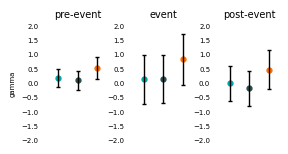

<Figure size 640x480 with 0 Axes>

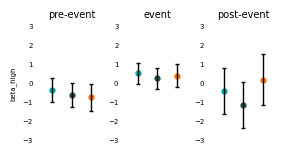

<Figure size 640x480 with 0 Axes>

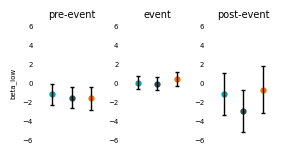

<Figure size 640x480 with 0 Axes>

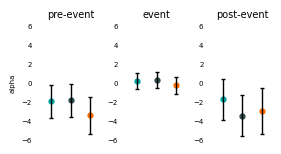

<Figure size 640x480 with 0 Axes>

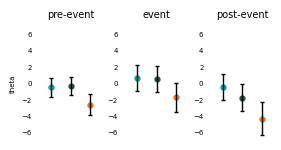

In [12]:
MNI_axis = "x"
plot_spatial_gradients(slopes, structure="cortex", frequency="gamma"    , MNI_axis=MNI_axis, ylim_min=-2, ylim_max=2)
plot_spatial_gradients(slopes, structure="cortex", frequency="beta_high", MNI_axis=MNI_axis, ylim_min=-3, ylim_max=3)
plot_spatial_gradients(slopes, structure="cortex", frequency="beta_low" , MNI_axis=MNI_axis, ylim_min=-6, ylim_max=6)
plot_spatial_gradients(slopes, structure="cortex", frequency="alpha"    , MNI_axis=MNI_axis, ylim_min=-6, ylim_max=6)
plot_spatial_gradients(slopes, structure="cortex", frequency="theta"    , MNI_axis=MNI_axis, ylim_min=-7, ylim_max=7)

<Figure size 640x480 with 0 Axes>

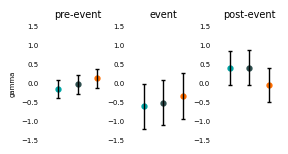

<Figure size 640x480 with 0 Axes>

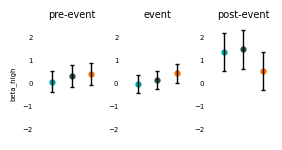

<Figure size 640x480 with 0 Axes>

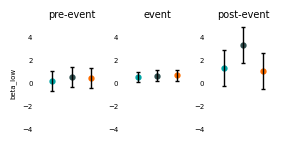

<Figure size 640x480 with 0 Axes>

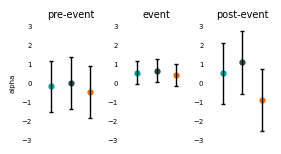

<Figure size 640x480 with 0 Axes>

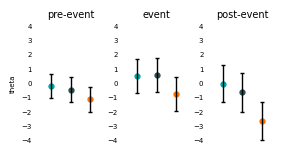

In [13]:
MNI_axis = "y"
plot_spatial_gradients(slopes, structure="cortex", frequency="gamma"    , MNI_axis=MNI_axis, ylim_min=-1.5, ylim_max=1.5)
plot_spatial_gradients(slopes, structure="cortex", frequency="beta_high", MNI_axis=MNI_axis, ylim_min=-2.5, ylim_max=2.5)
plot_spatial_gradients(slopes, structure="cortex", frequency="beta_low" , MNI_axis=MNI_axis, ylim_min=-5, ylim_max=5)
plot_spatial_gradients(slopes, structure="cortex", frequency="alpha"    , MNI_axis=MNI_axis, ylim_min=-3, ylim_max=3)
plot_spatial_gradients(slopes, structure="cortex", frequency="theta"    , MNI_axis=MNI_axis, ylim_min=-4, ylim_max=4)

In [14]:
conditions                  = [slopes_differences['p_value'] <= 0.001, slopes_differences['p_value'] <= 0.01, slopes_differences['p_value'] <= 0.05]
choices                     = ['***', '**', '*']
slopes_differences['stars'] = np.select(conditions, choices, default='')

In [46]:
slopes[(slopes.axis=="y") & (slopes.frequency=="gamma")]

,severity,slope,ci_lower,ci_upper,p_value,frequency,axis,event_segment,significant
75,noLID_noDOPA,-0.148,-0.387,0.091,0.677,gamma,y,pre,False
76,noLID_DOPA,-0.033,-0.286,0.219,0.795,gamma,y,pre,False
77,LID,0.132,-0.117,0.381,0.677,gamma,y,pre,False
81,noLID_noDOPA,-0.605,-1.194,-0.017,0.132,gamma,y,event,False
82,noLID_DOPA,-0.507,-1.107,0.093,0.196,gamma,y,event,False
83,LID,-0.335,-0.934,0.264,0.273,gamma,y,event,False
87,noLID_noDOPA,0.397,-0.040,0.834,0.226,gamma,y,post,False
88,noLID_DOPA,0.406,-0.044,0.857,0.226,gamma,y,post,False
89,LID,-0.043,-0.492,0.405,0.850,gamma,y,post,False


In [56]:
slopes_differences[(slopes_differences.axis=="y") & (slopes_differences.frequency=="gamma")]

,comparison,slope_diff,ci_lower,ci_upper,p_value,frequency,axis,event_segment,significant,stars
75,noLID-noDOPA vs noLID-DOPA,-0.114,-0.272,0.043,0.307,gamma,y,pre,False,
76,noLID-DOPA vs LID,-0.165,-0.392,0.062,0.307,gamma,y,pre,False,
77,noLID-noDOPA vs LID,-0.280,-0.490,-0.069,0.028,gamma,y,pre,True,*
81,noLID-noDOPA vs noLID-DOPA,-0.098,-0.318,0.121,0.611,gamma,y,event,False,
82,noLID-DOPA vs LID,-0.172,-0.501,0.157,0.611,gamma,y,event,False,
83,noLID-noDOPA vs LID,-0.270,-0.577,0.036,0.251,gamma,y,event,False,
87,noLID-noDOPA vs noLID-DOPA,-0.010,-0.219,0.200,0.929,gamma,y,post,False,
88,noLID-DOPA vs LID,0.450,0.139,0.760,0.009,gamma,y,post,True,**
89,noLID-noDOPA vs LID,0.440,0.152,0.728,0.008,gamma,y,post,True,**
